In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [144]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [145]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount
0,2014,1,88
229447,2011,1,10
156483,2012,1,50
76159,2013,1,8
76160,2013,1,16


In [146]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()


In [7]:
print(bank_df.head()) #check dataframe for columns
print(inc_df.head())

       year  income  amount      mult       pct_amt  cumul_amt_pct   pct_inc  \
7036   2014      56       7  0.125000  1.892840e-07   1.892840e-07  0.000004   
9916   2014      67       8  0.119403  2.163245e-07   4.056085e-07  0.000004   
1090   2014      25       8  0.320000  2.163245e-07   6.219331e-07  0.000002   
1468   2014      28       9  0.321429  2.433651e-07   8.652982e-07  0.000002   
33498  2014     140      10  0.071429  2.704057e-07   1.135704e-06  0.000009   

       cumul_inc_pct  
7036        0.000004  
9916        0.000008  
1090        0.000009  
1468        0.000011  
33498       0.000020  
        year  income  amount       pct_amt  cumul_amt_pct       pct_inc  \
0       2014       1      88  6.783152e-07   6.783152e-07  1.704434e-08   
229447  2011       1      10  7.708127e-08   7.553965e-07  1.704434e-08   
156483  2012       1      50  3.854064e-07   1.140803e-06  1.704434e-08   
76159   2013       1       8  6.166502e-08   1.202468e-06  1.704434e-08   
76160 

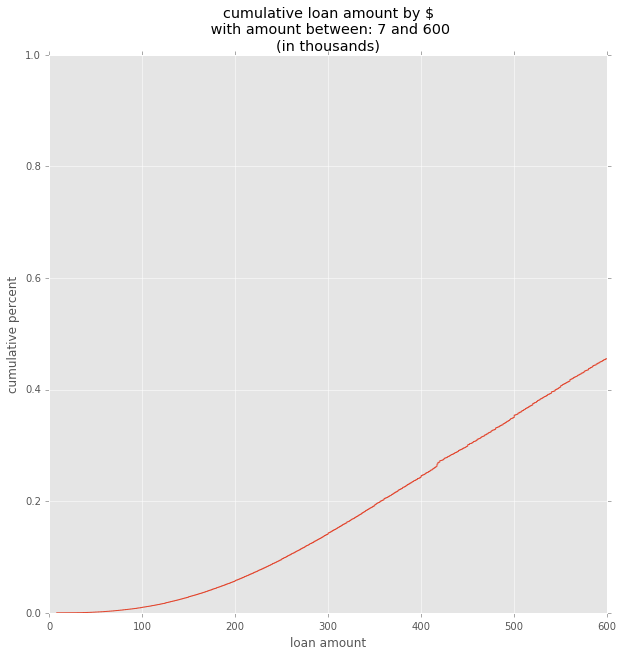

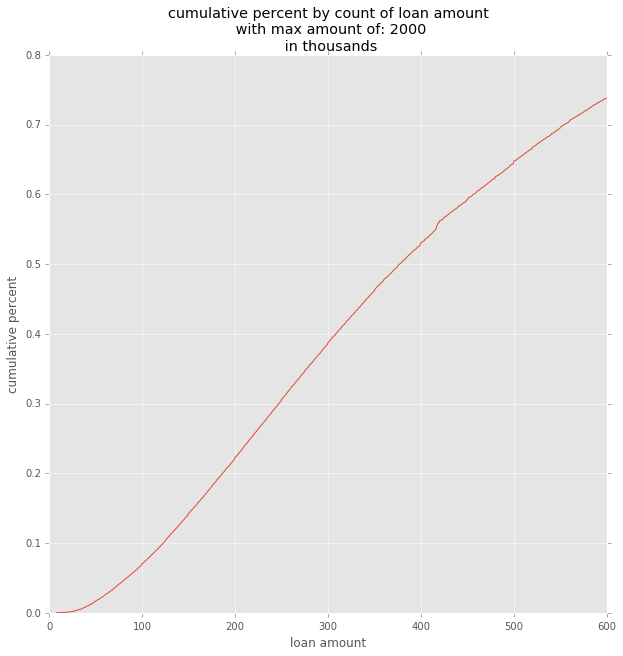

In [98]:
#FIXME add cutoff field name and cutoff value to title
#graph cumulative sum of % of income and % of loan amount 
amt_min = bank_df.amount.min()
amt_max = 600#bank_df.amount.max()

y = bank_df.cumul_amt_pct[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
x = bank_df.amount[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
cumul_pct = plt.figure(figsize=(10,10))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative loan amount by $\n with amount between: {amt_min} and {amt_max}\n(in thousands)'.format(amt_min=amt_min, amt_max=amt_max))
plt.ylabel('cumulative percent')
plt.xlabel('loan amount')
plt.show(cumul_pct)

#y1 = bank_df.cumul_cnt_pct_amt[bank_df[cut_field] < amt_cutoff]
x1 = cnt_amt_df.amount[(cnt_amt_df.amount < amt_max) & (cnt_amt_df.amount > amt_min)]
y1 = cnt_amt_df.cumul_pct_cnt[(cnt_amt_df.amount < amt_max) & ( cnt_amt_df.amount > amt_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
plt.xlabel('loan amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of loan amount\n with max amount of: {amt}\n in thousands'.format(amt=amt_cutoff))
plt.show(cumul_cnt)


#FIXME modify these graphs by reducing the range of the x axis to see the cumulative curve better
#measureing the $ value of loans shows a high degree of skew due to very large loan amounts
#cutting the tail off the data may be more informative
#the majority of loans by count are under 450-500k, but the raw $ value majority is closer to 2million

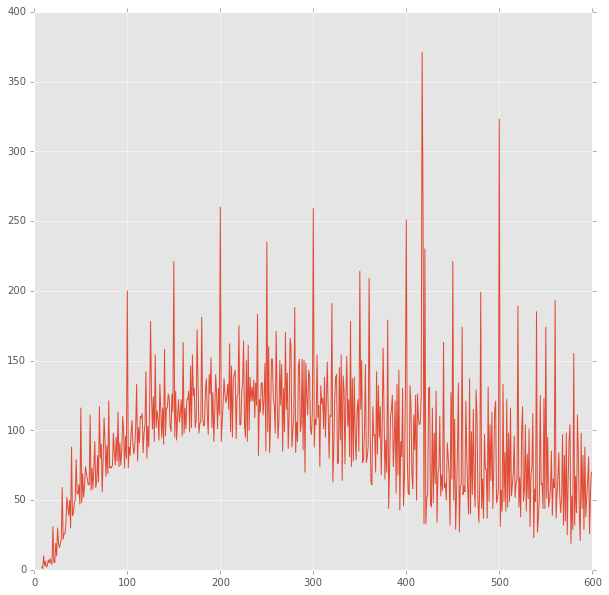

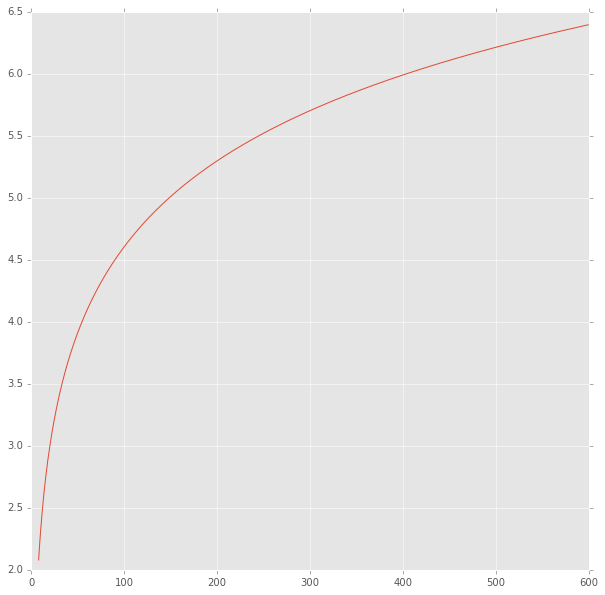

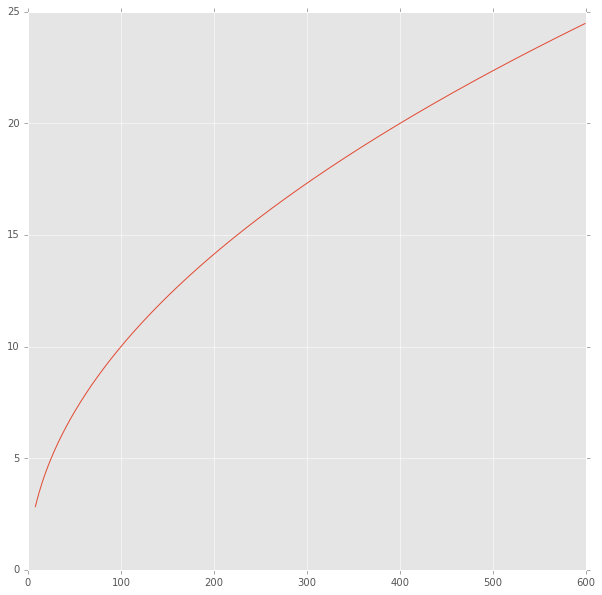

In [100]:
from math import log, sqrt
amt_dist = pd.DataFrame(bank_df.groupby('amount').mult.count())
amt_dist.rename(columns={'mult':'count_amt'},inplace=True)
amt_dist['amount'] = amt_dist.index
amt_dist['amt_log'] = amt_dist.amount.apply(log)
amt_dist['amt_sqrt'] = amt_dist.amount.apply(sqrt)
amt_dist.head()
amt_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y1 = amt_dist.count_amt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
amt_x1 = amt_dist.amount[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]


plt.plot(amt_x1,amt_y1)
plt.show(amt_fig)

#plot logs of amount
log_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y2 = amt_dist.amt_log[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y2)
plt.show(log_fig)

#plot sqrt of amount
sqrt_fig = plt.figure(figsize=(10,10))
amt_y3 = amt_dist.amt_sqrt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y3)
plt.show(sqrt_fig)



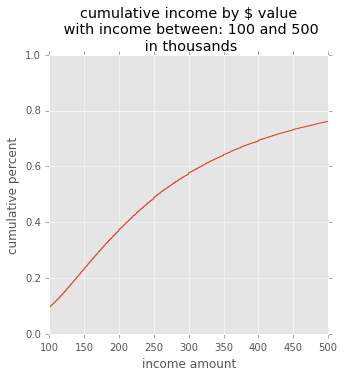

In [26]:
#showing cumulative percent of count of loans by income
#inc_cutoff allows trims max end of distribution
inc_min = 100
inc_max = 500
y = inc_df.cumul_inc_pct[(inc_df.income < inc_max) & (inc_df.income > inc_min)]
x = inc_df.income[(inc_df.income < inc_max) &(inc_df.income > inc_min)]

cumul_inc = plt.figure(figsize=(5,5))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative income by $ value\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.ylabel('cumulative percent')
plt.xlabel('income amount')
plt.show(cumul_inc)


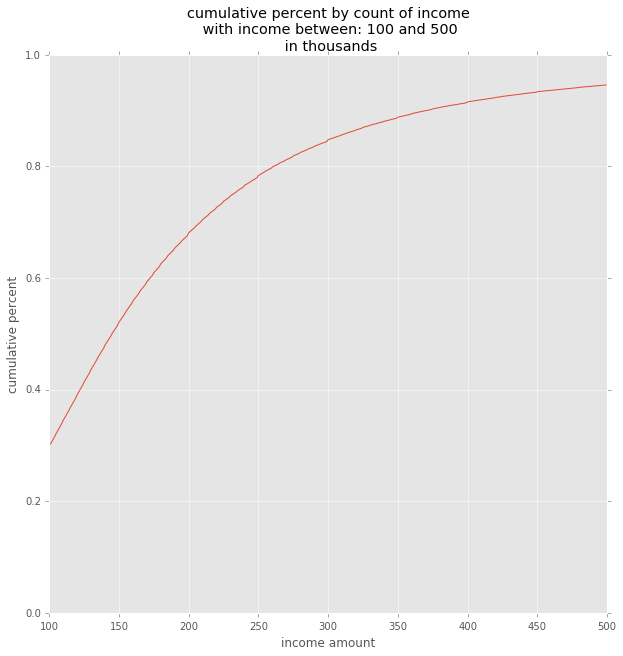

In [27]:
x1 = cnt_inc_df.income[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
y1 = cnt_inc_df.cumul_pct_cnt[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.xlabel('income amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of income\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.show(cumul_cnt)

400.963857957 std
442.363262216 mean
338.0 median
2500.0 max mult
0.00314465408805 min mult
1600.0 98%
559.0 q3
199.0 q1
48.0 02%
360.0 iqr
-341.0 min_q 1099.0 max_q


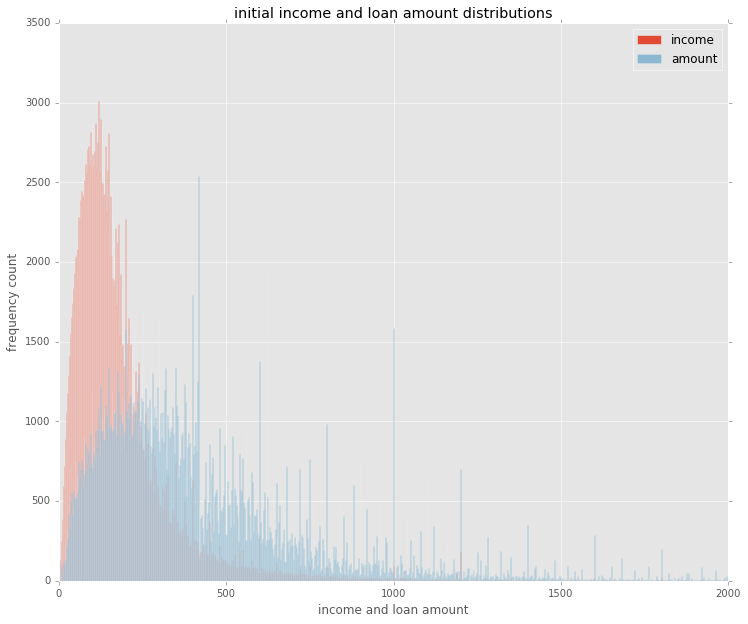

In [147]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), 'q98')
print(bank_df.amount.quantile(q=.75), 'q75')
print(bank_df.amount.quantile(q=.25), 'q25')
print(bank_df.amount.quantile(q=.02), 'q02')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr #potential lower bound for quality
max_q = q3 + 1.5*iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz

name 0 to 20
std 144.507658256
mean 112.137249115
median 75.0
max_mult 2500.0
med_mult 5.277777777777778
min_mult 0.0526315789474
q98 433.38
q02 15.0
q75 128.0
q25 46.0
iqr 82.0
min_q -77.0
max_q 251.0
count of loans 3388
pct of total loans 1.15523761137


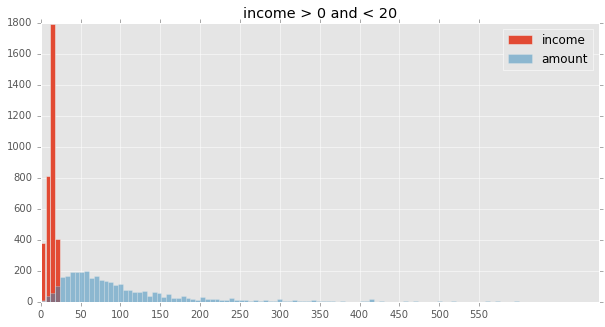

name 20 to 50
std 94.964791769
mean 133.704921043
median 119.0
max_mult 100.885714286
med_mult 3.4130434782608696
min_mult 0.030303030303
q98 345.0
q02 23.0
q75 175.0
q25 72.0
iqr 103.0
min_q -82.5
max_q 329.5
count of loans 21784
pct of total loans 7.42789141858


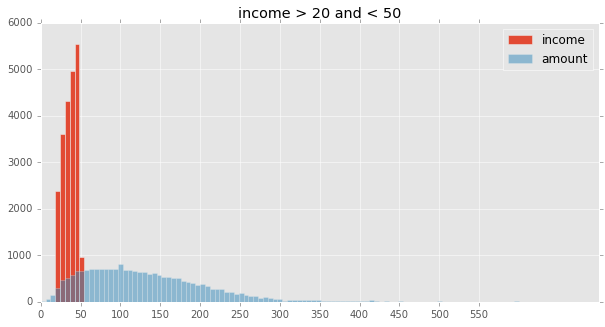

name 50 to 80
std 134.994458449
mean 201.014223799
median 191.0
max_mult 237.857142857
med_mult 2.966666666666667
min_mult 0.0645161290323
q98 417.0
q02 36.0
q75 269.0
q25 118.0
iqr 151.0
min_q -108.5
max_q 495.5
count of loans 34379
pct of total loans 11.7225247466


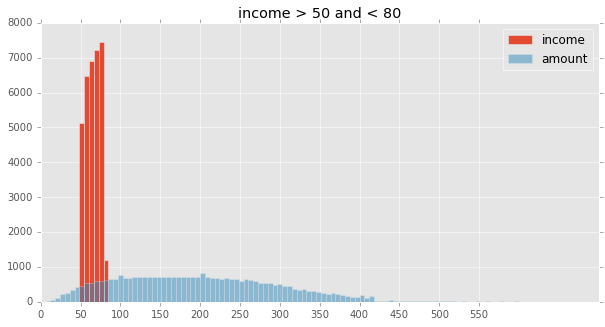

name 80 to 110
std 132.701350926
mean 262.734902943
median 251.0
max_mult 23.6860465116
med_mult 2.656862745098039
min_mult 0.0747663551402
q98 550.0
q02 53.0
q75 348.0
q25 162.0
iqr 186.0
min_q -117.0
max_q 627.0
count of loans 39925
pct of total loans 13.6135955236


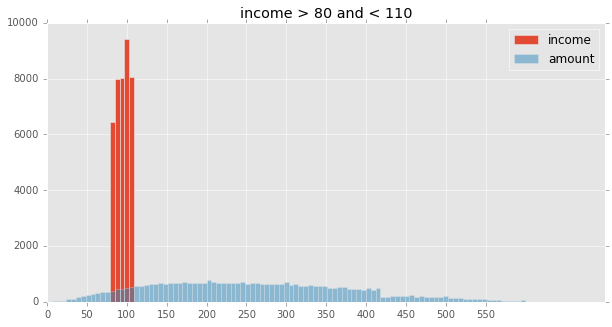

name 110 to 140
std 157.855302444
mean 324.158143174
median 306.0
max_mult 22.7272727273
med_mult 2.4642857142857144
min_mult 0.0545454545455
q98 670.0
q02 75.0
q75 414.0
q25 207.0
iqr 207.0
min_q -103.5
max_q 724.5
count of loans 39616
pct of total loans 13.5082329434


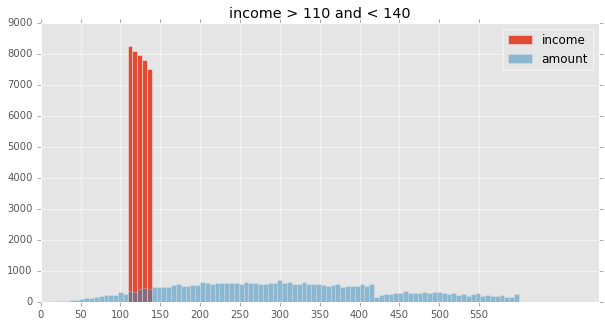

name 140 to 170
std 182.189885496
mean 382.587278857
median 356.0
max_mult 15.5844155844
med_mult 2.3142857142857145
min_mult 0.0533333333333
q98 804.0
q02 95.0
q75 499.0
q25 250.0
iqr 249.0
min_q -123.5
max_q 872.5
count of loans 33519
pct of total loans 11.4292826138


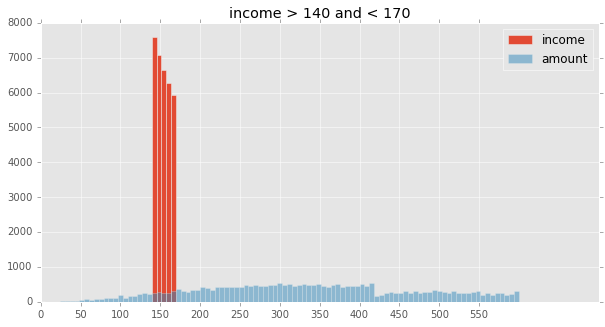

name 170 to 200
std 211.128876593
mean 441.688590657
median 404.0
max_mult 21.4827586207
med_mult 2.205266805266805
min_mult 0.0454545454545
q98 960.0
q02 116.0
q75 567.0
q25 290.0
iqr 277.0
min_q -125.5
max_q 982.5
count of loans 25558
pct of total loans 8.71474701046


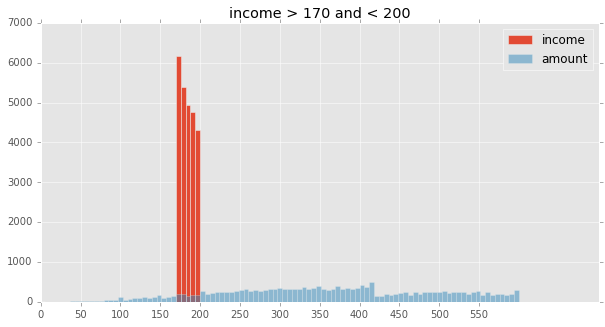

name 200 to 230
std 240.364941636
mean 506.729051109
median 476.0
max_mult 14.2718446602
med_mult 2.231132075471698
min_mult 0.0384615384615
q98 1100.0
q02 129.0
q75 640.0
q25 331.75
iqr 308.25
min_q -130.625
max_q 1102.375
count of loans 20192
pct of total loans 6.88505249375


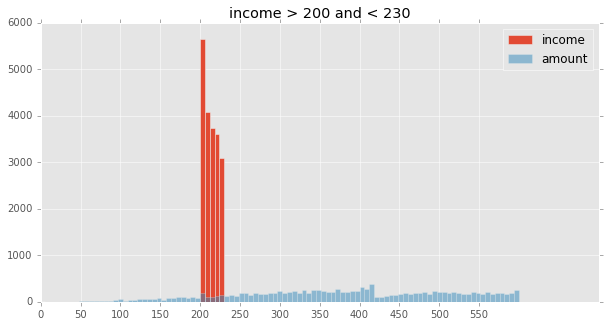

name 230 to 260
std 272.683122325
mean 572.076958374
median 544.0
max_mult 16.743697479
med_mult 2.2222222222222223
min_mult 0.0965250965251
q98 1248.0
q02 144.08
q75 720.0
q25 373.0
iqr 347.0
min_q -147.5
max_q 1240.5
count of loans 15255
pct of total loans 5.20163806419


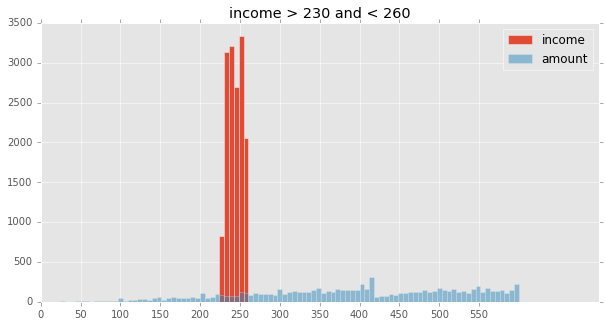

name 260 to 290
std 308.847889074
mean 638.372531337
median 599.0
max_mult 14.6210526316
med_mult 2.183098591549296
min_mult 0.0280701754386
q98 1400.0
q02 158.0
q75 808.0
q25 410.0
iqr 398.0
min_q -187.0
max_q 1405.0
count of loans 11089
pct of total loans 3.78111861644


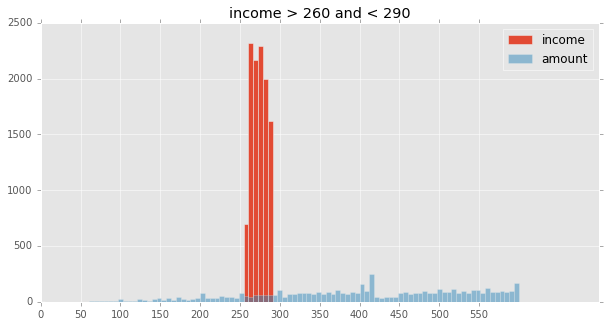

name 290 to 320
std 338.487324164
mean 701.102790858
median 650.0
max_mult 7.86392405063
med_mult 2.147766323024055
min_mult 0.0253968253968
q98 1500.0
q02 165.0
q75 911.5
q25 443.0
iqr 468.5
min_q -259.75
max_q 1614.25
count of loans 8707
pct of total loans 2.96890610455


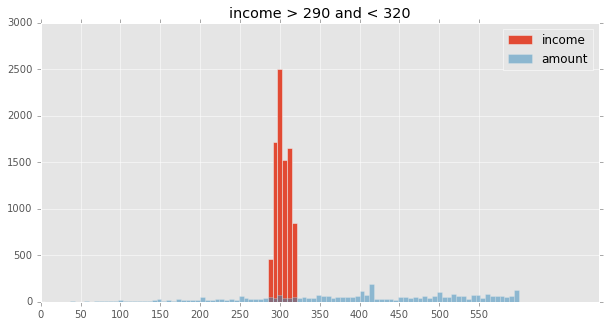

name 320 to 350
std 365.558324158
mean 758.680939227
median 700.0
max_mult 7.25757575758
med_mult 2.0987654320987654
min_mult 0.14450867052
q98 1680.0
q02 185.6
q75 990.0
q25 494.75
iqr 495.25
min_q -248.125
max_q 1732.875
count of loans 6516
pct of total loans 2.22182062447


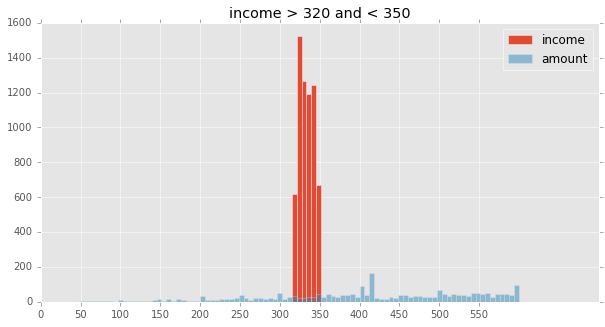

name 350 to 380
std 399.090144937
mean 798.326951131
median 729.0
max_mult 8.78378378378
med_mult 2.0
min_mult 0.139275766017
q98 1784.34
q02 174.66
q75 1040.0
q25 506.0
iqr 534.0
min_q -295.0
max_q 1841.0
count of loans 5484
pct of total loans 1.86993006516


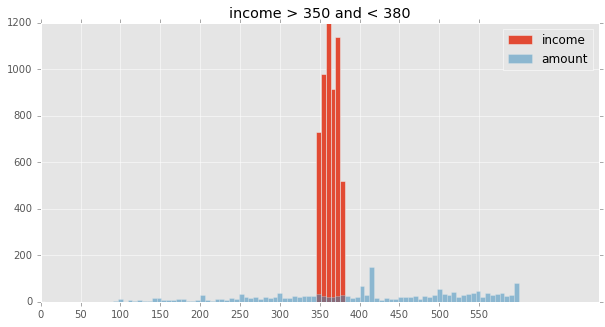

name 380 to 410
std 438.199240319
mean 851.900216398
median 780.0
max_mult 16.4141414141
med_mult 1.974025974025974
min_mult 0.05
q98 1909.24
q02 199.16
q75 1116.0
q25 535.5
iqr 580.5
min_q -335.25
max_q 1986.75
count of loans 4159
pct of total loans 1.41813259318


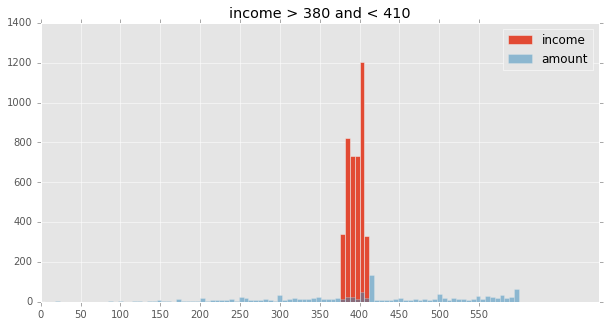

name 410 to 440
std 455.064428725
mean 902.926681543
median 847.0
max_mult 11.7511520737
med_mult 2.0
min_mult 0.0571428571429
q98 2000.0
q02 200.0
q75 1200.0
q25 560.0
iqr 640.0
min_q -400.0
max_q 2160.0
count of loans 3137
pct of total loans 1.06965182611


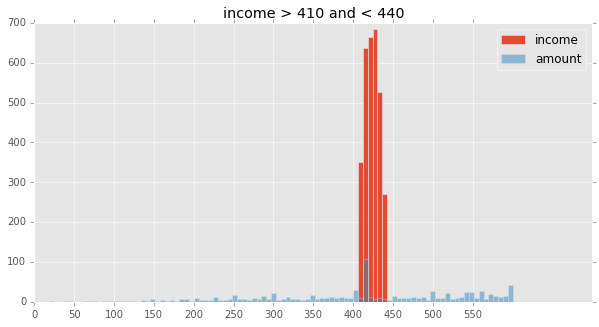

name 440 to 470
std 478.063465038
mean 921.613291877
median 852.0
max_mult 8.44086021505
med_mult 1.8888888888888888
min_mult 0.0789473684211
q98 2000.0
q02 200.0
q75 1218.0
q25 560.0
iqr 658.0
min_q -427.0
max_q 2205.0
count of loans 2573
pct of total loans 0.877339543702


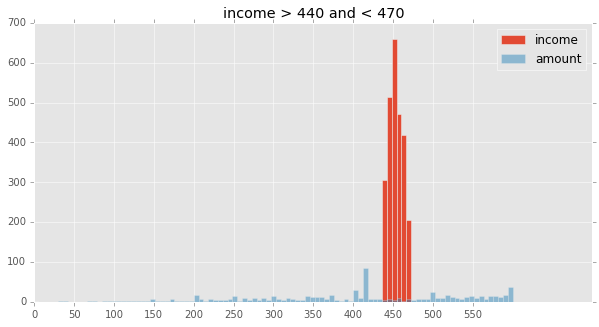

name 470 to 500
std 513.304036318
mean 966.189379699
median 893.5
max_mult 8.28080808081
med_mult 1.8397192009359968
min_mult 0.0801603206413
q98 2000.0
q02 200.0
q75 1306.0
q25 573.25
iqr 732.75
min_q -525.875
max_q 2405.125
count of loans 2128
pct of total loans 0.725603788961


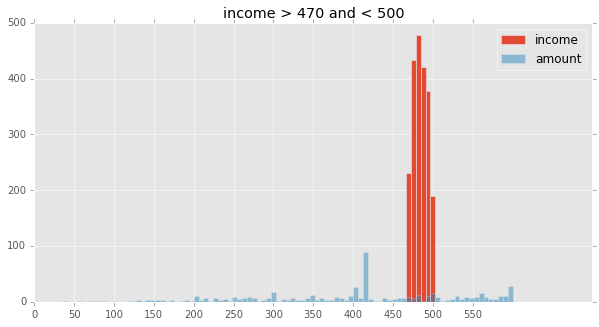

name 500 to 530
std 522.398270703
mean 1002.17860798
median 940.0
max_mult 6.26377952756
med_mult 1.8261599511599511
min_mult 0.05
q98 2167.14
q02 196.0
q75 1340.0
q25 611.25
iqr 728.75
min_q -481.875
max_q 2433.125
count of loans 1954
pct of total loans 0.666273403961


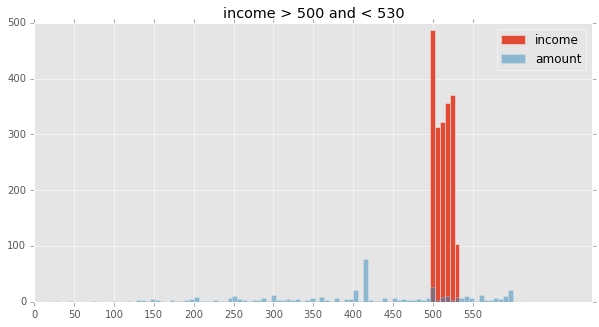

name 530 to 560
std 556.413634704
mean 1009.72675522
median 945.0
max_mult 7.03703703704
med_mult 1.7328519855595668
min_mult 0.103825136612
q98 2326.0
q02 194.6
q75 1358.0
q25 595.0
iqr 763.0
min_q -549.5
max_q 2502.5
count of loans 1581
pct of total loans 0.539088153359


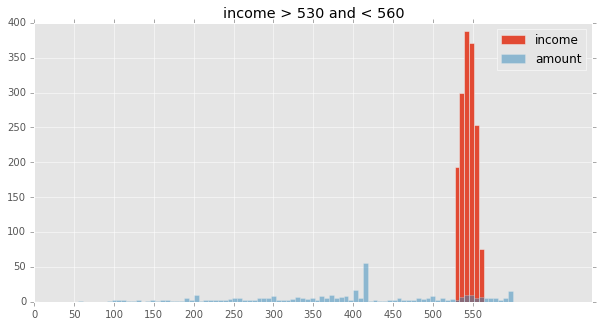

name 560 to 590
std 544.477479121
mean 1051.45367412
median 980.0
max_mult 6.12587412587
med_mult 1.705934309592846
min_mult 0.0557491289199
q98 2309.8
q02 239.06
q75 1388.5
q25 627.5
iqr 761.0
min_q -514.0
max_q 2530.0
count of loans 1252
pct of total loans 0.426905988618


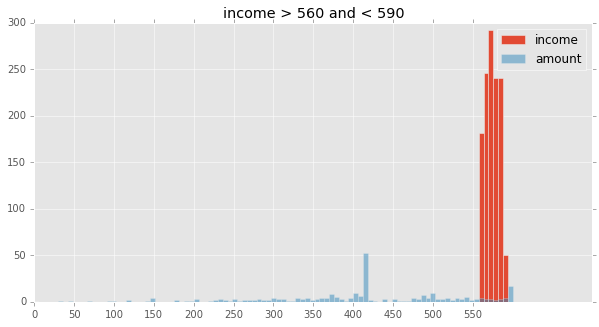

name 590 to 620
std 613.624500276
mean 1100.27782498
median 1004.0
max_mult 8.37520938023
med_mult 1.6863406408094435
min_mult 0.0780487804878
q98 2501.44
q02 173.76
q75 1480.0
q25 627.0
iqr 853.0
min_q -652.5
max_q 2759.5
count of loans 1177
pct of total loans 0.401332546808


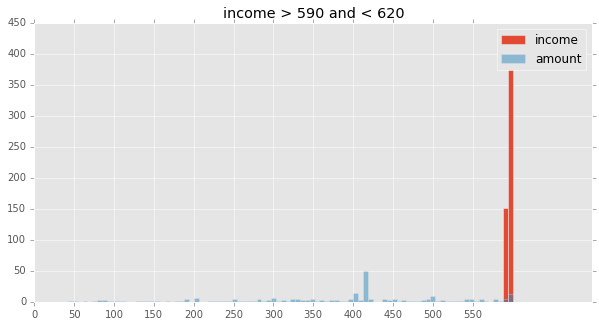

name 620 to 650
std 583.457945665
mean 1118.2875
median 1050.0
max_mult 4.97284345048
med_mult 1.6546833385305109
min_mult 0.0283018867925
q98 2497.1
q02 184.74
q75 1500.0
q25 644.5
iqr 855.5
min_q -638.75
max_q 2783.25
count of loans 880
pct of total loans 0.30006171724


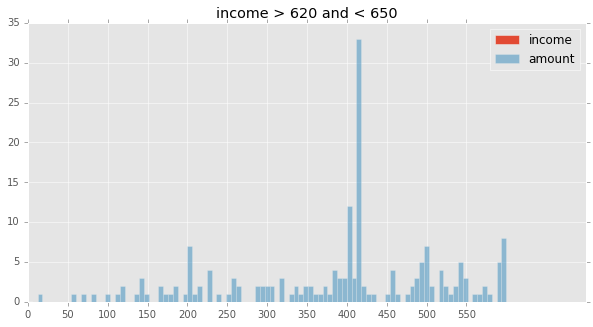

name 650 to 680
std 642.824906776
mean 1145.04028436
median 1020.0
max_mult 7.27272727273
med_mult 1.5468393965129175
min_mult 0.113636363636
q98 2704.2
q02 200.0
q75 1533.5
q25 659.5
iqr 874.0
min_q -651.5
max_q 2844.5
count of loans 844
pct of total loans 0.287786465171


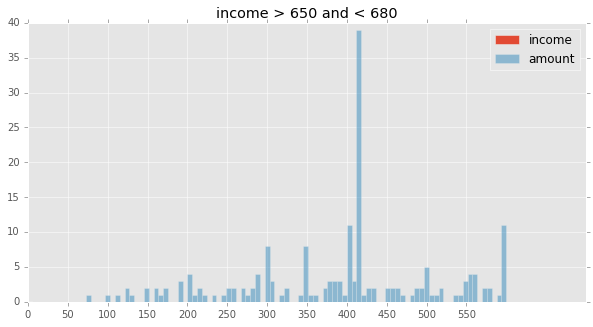

name 680 to 710
std 606.803103325
mean 1137.98023715
median 1076.0
max_mult 5.29538904899
med_mult 1.5451895043731778
min_mult 0.0845481049563
q98 2644.0
q02 200.0
q75 1516.0
q25 654.0
iqr 862.0
min_q -639.0
max_q 2809.0
count of loans 759
pct of total loans 0.258803231119


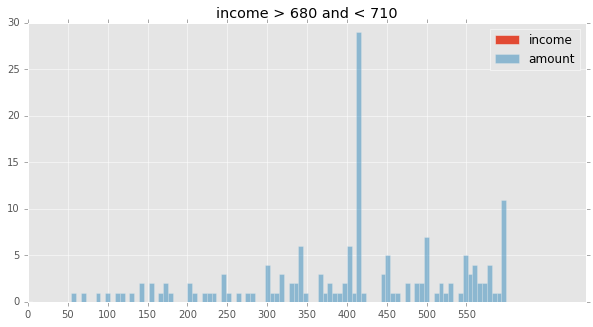

name 710 to 740
std 656.138000734
mean 1151.18530351
median 1040.0
max_mult 6.98324022346
med_mult 1.437418755803157
min_mult 0.0208333333333
q98 2707.0
q02 193.0
q75 1581.75
q25 661.25
iqr 920.5
min_q -719.5
max_q 2962.5
count of loans 626
pct of total loans 0.213452994309


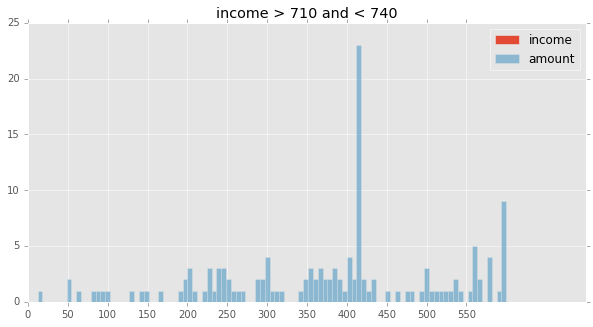

In [148]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 20
bin_step = 30
pct_of_loans = OrderedDict({})
first = True
while bin_max < 751:
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['med_mult'] = graph_bin.mult.median()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100
    
    if first:
        first=False
        bin_df = pd.DataFrame(bin_stats, index=range(1))
    else:

        concat_df = pd.DataFrame(bin_stats, index=range(1))
        bin_df = pd.concat([bin_df, concat_df], axis=0)
    for key, value in bin_stats.items():
        print(key,value)
    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 600 #set maximum x axis value
    xsteps= 100 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
bin_df.reset_index(inplace=True, drop=True)

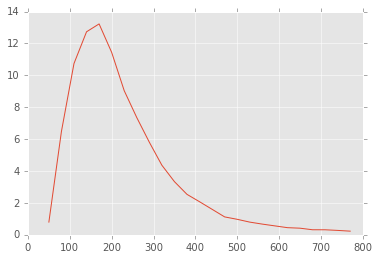

In [140]:
#graph percent of loans by top of income bin
y = []
x = []
for key, value in pct_of_loans.items():
    y.append(value)
    x.append(key)
plt.plot(x,y)


In [141]:
#make data adjustments and calculate desc stat deltas and regraph
#use this work to refine income bins and associated loan amount distributions



In [149]:
path = 'linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'no_mod.csv')

In [150]:
bin_df.head(100)

,name,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0 to 20,144.507658,112.137249,75.0,2500.000000,5.277778,0.052632,433.38,15.00,128.00,46.00,82.00,-77.000,251.000,3388,1.155238
1,20 to 50,94.964792,133.704921,119.0,100.885714,3.413043,0.030303,345.00,23.00,175.00,72.00,103.00,-82.500,329.500,21784,7.427891
2,50 to 80,134.994458,201.014224,191.0,237.857143,2.966667,0.064516,417.00,36.00,269.00,118.00,151.00,-108.500,495.500,34379,11.722525
3,80 to 110,132.701351,262.734903,251.0,23.686047,2.656863,0.074766,550.00,53.00,348.00,162.00,186.00,-117.000,627.000,39925,13.613596
4,110 to 140,157.855302,324.158143,306.0,22.727273,2.464286,0.054545,670.00,75.00,414.00,207.00,207.00,-103.500,724.500,39616,13.508233
5,140 to 170,182.189885,382.587279,356.0,15.584416,2.314286,0.053333,804.00,95.00,499.00,250.00,249.00,-123.500,872.500,33519,11.429283
6,170 to 200,211.128877,441.688591,404.0,21.482759,2.205267,0.045455,960.00,116.00,567.00,290.00,277.00,-125.500,982.500,25558,8.714747
7,200 to 230,240.364942,506.729051,476.0,14.271845,2.231132,0.038462,1100.00,129.00,640.00,331.75,308.25,-130.625,1102.375,20192,6.885052
8,230 to 260,272.683122,572.076958,544.0,16.743697,2.222222,0.096525,1248.00,144.08,720.00,373.00,347.00,-147.500,1240.500,15255,5.201638
9,260 to 290,308.847889,638.372531,599.0,14.621053,2.183099,0.028070,1400.00,158.00,808.00,410.00,398.00,-187.000,1405.000,11089,3.781119


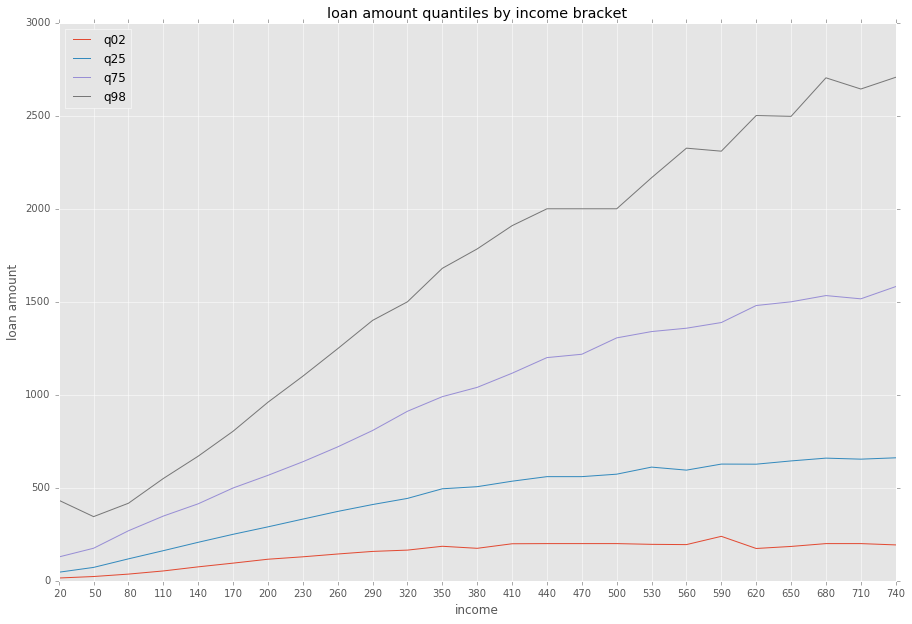

In [152]:
fig = plt.figure(figsize=(15,10))
xticks=[x[-3:] for x in bin_df.name] #get xtick names as list
ax = plt.subplot()
plt.xticks(x,xticks) #set xtick names
x = range(len(bin_df.name))

y = bin_df.q02
y1 = bin_df.q25
y2 = bin_df.q75
y3 = bin_df.q98
plt.plot(x,y, label='q02')
plt.plot(x,y1, label='q25')
plt.plot(x,y2, label='q75')
plt.plot(x,y3, label='q98')
plt.ylabel('loan amount')
plt.xlabel('income')
plt.legend(loc='upper left') #turn on legend and set location
plt.title('loan amount quantiles by income bracket')
plt.show(fig)


In [ ]:
#exclude data with quality edit fails